In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap, random, devices
import jax
import flax
from flax.training import train_state
from flax import linen as nn
import optax

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

**Training the model on historical time series**

In [ ]:
stock = pd.read_csv('...Microsoft time series/all_stocks_2006-01-01_to_2018-01-01.csv')

In [ ]:
names = stock.Name.unique()

In [ ]:
train = pd.DataFrame()
for name in names:
  curr_close = pd.DataFrame(stock[stock['Name'] == name]['Close'])
  curr_close.columns = ['Close']
  window = 21
  for i in range(1, window + 1):
    curr_close.loc[:, f'prev_val_{i}'] = curr_close['Close'].shift(i)
  train = pd.concat([train,curr_close])

train.dropna(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92961 entries, 21 to 93611
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close        92961 non-null  float64
 1   prev_val_1   92961 non-null  float64
 2   prev_val_2   92961 non-null  float64
 3   prev_val_3   92961 non-null  float64
 4   prev_val_4   92961 non-null  float64
 5   prev_val_5   92961 non-null  float64
 6   prev_val_6   92961 non-null  float64
 7   prev_val_7   92961 non-null  float64
 8   prev_val_8   92961 non-null  float64
 9   prev_val_9   92961 non-null  float64
 10  prev_val_10  92961 non-null  float64
 11  prev_val_11  92961 non-null  float64
 12  prev_val_12  92961 non-null  float64
 13  prev_val_13  92961 non-null  float64
 14  prev_val_14  92961 non-null  float64
 15  prev_val_15  92961 non-null  float64
 16  prev_val_16  92961 non-null  float64
 17  prev_val_17  92961 non-null  float64
 18  prev_val_18  92961 non-null  float64
 19  pre

In [ ]:
train_shuffled = train.to_numpy()
np.random.shuffle(train_shuffled)

In [ ]:
y_train = train_shuffled[:,:3]
X_train = train_shuffled[:,3:]

In [ ]:
class myLSTM(nn.Module):
  features: int

  def setup(self):
    self.scan_cell = nn.scan(
      nn.OptimizedLSTMCell,
      variable_broadcast='params',
      in_axes=1, out_axes=1,
      split_rngs={'params': False})(self.features)
    self.attention = nn.MultiHeadDotProductAttention(num_heads=1)

  @nn.compact
  def __call__(self, x):
    (carry, hidden) = self.scan_cell.initialize_carry(jax.random.key(0), x[:, 0].shape)
    (carry, hidden), x = self.scan_cell((carry, hidden), x)
    x = self.attention(inputs_q=x, inputs_kv=x)
    x = nn.Dense(32)(x[:,0,:])
    x = nn.relu(x)
    x = nn.Dense(3)(x)
    return x

In [ ]:
from flax.training import train_state

def create_train_state(rng):
  params = model.init(rng, jnp.array(X_train.reshape(-1,19,1)))['params']
  tx = optax.adam(1e-4,0.85,0.97)
  return train_state.TrainState.create(
      apply_fn=model.apply, params=params, tx=tx)

In [ ]:
rng = jax.random.PRNGKey(0)
rng, input_rng, init_rng = jax.random.split(rng,num=3)

model = myLSTM(features = 64)

seed = 0

state = create_train_state(init_rng)

model.apply({'params': state.params}, X_train[:10].reshape(-1,19,1)).shape

(10, 3)

In [ ]:
def compute_metrics(logits, labels):
  loss = jnp.mean(optax.squared_error(logits, labels))
  metrics = {
      'loss': loss
  }
  return metrics

In [ ]:
@jax.jit
def train_step(state, X, y):
  def loss_fn(params):
    logits = model.apply({'params': params}, X)
    loss = jnp.mean(optax.squared_error(logits, y.reshape(-1,3)))
    return loss, logits
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (_, logits), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  metrics = compute_metrics(logits, y.reshape(-1,3))
  return state, metrics

In [ ]:
def train_model(state, X, y, num_epochs, batch_size):
    # Training loop
    for epoch in range(num_epochs):
      for i in range(X.shape[0] // batch_size):
        batch_X = X[i*batch_size: i*batch_size + batch_size]
        batch_y= y[i*batch_size: i*batch_size + batch_size]
        state, metrics = train_step(state, batch_X, batch_y)
      if epoch % 100 == 0:
        print(metrics)
    return state

In [ ]:
rng = jax.random.PRNGKey(0)
rng, input_rng, init_rng = jax.random.split(rng,num=3)

model = myLSTM(features = 64)

seed = 45

state = create_train_state(init_rng)
del init_rng

In [ ]:
trained_model_state = train_model(state, X_train.reshape(-1,19,1), y_train, num_epochs=1000, batch_size=1000)

{'loss': Array(18030.871, dtype=float32)}
{'loss': Array(6.8592916, dtype=float32)}
{'loss': Array(6.160615, dtype=float32)}
{'loss': Array(5.715201, dtype=float32)}
{'loss': Array(5.149448, dtype=float32)}
{'loss': Array(4.910259, dtype=float32)}
{'loss': Array(4.791744, dtype=float32)}
{'loss': Array(4.7249584, dtype=float32)}
{'loss': Array(4.7023025, dtype=float32)}
{'loss': Array(4.7110906, dtype=float32)}


In [ ]:
preds = model.apply({'params': trained_model_state.params}, X_train[0].reshape(-1,19,1))
print('Test:', y_train[0])
print('Preds:', preds[0])

Test: [19.39 19.63 19.6 ]
Preds: [20.261118 20.23838  20.205559]


**Testing the model on MS time series**

<Axes: >

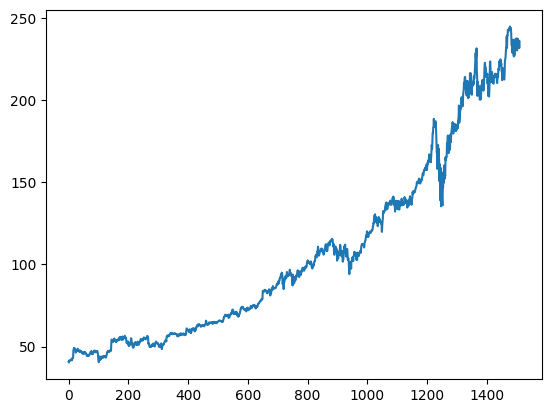

In [ ]:
MSts = pd.read_csv('...Microsoft time series/Microsoft_Stock.csv')
MSts['Close'].plot()

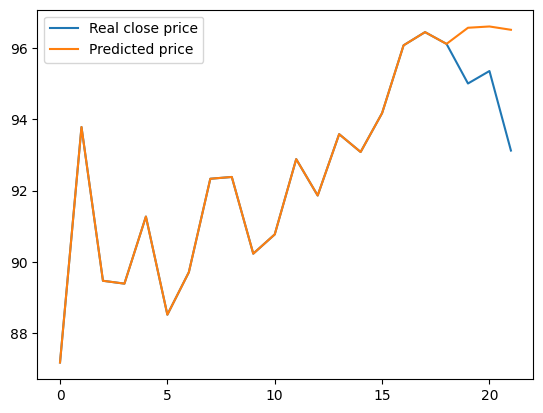

In [ ]:
test = MSts.Close.to_numpy()
start = 750
x = test[start:start+19]
y = test[start+19:start+22]

preds = model.apply({'params': trained_model_state.params}, np.flip(x.reshape(-1,19,1)))

plt.plot(np.concatenate((x,y)))
plt.plot(np.concatenate((x, np.flip(preds.reshape(-1)))))
plt.legend(['Real close price', 'Predicted price'])

In [ ]:
import pickle

pkl_filename = "/content/drive/MyDrive/Resume/Microsoft time series/model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

param_filename = "/content/drive/MyDrive/Resume/Microsoft time series/param.pkl"
with open(param_filename, 'wb') as file:
    pickle.dump(trained_model_state.params, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

with open(param_filename, 'rb') as file:
  pickle_model_state = pickle.load(file)